In [ ]:
from numpy import concatenate
from pandas import read_excel
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import plotly.graph_objects as go


Accessing drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Reading data from the excel file

In [ ]:
dfr = read_excel(r'/content/drive/My Drive/CMIE_PROJECT/panel.xlsx', sheet_name='mainpanel')

Dropping irrelevant variables

In [ ]:
dfr = dfr.drop(columns=['Total assets','Net fixed assets','Export / Sales (%)','IT/ITES & other professional services','Additions to computers and IT systems during the year','Gross software','Net profit margin','Net cash inflow or (outflow) from investing activities','Size','Total forex earnings / Total income (%)','Raw material imports / Raw material purchases (%)', 'Gross computers and IT systems'])


In [ ]:
df=dfr.copy()

Filling missing values, linearly

In [ ]:
def fill_nan_linearly(column):
    return column.fillna(method='ffill').fillna(method='bfill')
filled_df = df.groupby('Companies').apply(lambda group: group.apply(fill_nan_linearly, axis=0))
filled_df.reset_index(drop=True, inplace=True)

In [ ]:
df=filled_df.copy()

Mathematical manipulation to avoid explosion in mape value

In [ ]:
for i in df.columns:
  df.loc[df[i] == 0, i] = 0.1

Train Test Split

In [ ]:
train = df[df['Year'] < 2020]
test = df[df['Year'] >= 2021]

In [ ]:
X_train = train.drop(['Total income'], axis=1)
Y_train = DataFrame(train['Total income'])
X_test = test.drop(['Total income'], axis=1)
Y_test = DataFrame(test['Total income'])

Converting Data to supervised format

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg


Reshaping the data

In [ ]:
def reshape_data(train,test):
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)

    train= reframed_train.values
    test=reframed_test.values

    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]

    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

Converting categorical labels into numeric values

In [ ]:
encoder = LabelEncoder()

train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['Companies']= encoder.fit_transform(train_data['Companies'])

test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['Companies']= encoder.fit_transform(test_data['Companies'])

In [ ]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

Model

In [ ]:
model = Sequential()
model.add(GRU(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(x_train, y_train, epochs=50, batch_size=50,  verbose=1, shuffle=False)

Epoch 1/50
802/802 [==============================] - 6s 5ms/step - loss: 1620.1708
Epoch 2/50
802/802 [==============================] - 3s 4ms/step - loss: 700.3201
Epoch 3/50
802/802 [==============================] - 2s 3ms/step - loss: 493.9768
Epoch 4/50
802/802 [==============================] - 3s 4ms/step - loss: 425.7130
Epoch 5/50
802/802 [==============================] - 3s 3ms/step - loss: 389.3691
Epoch 6/50
802/802 [==============================] - 4s 5ms/step - loss: 354.6677
Epoch 7/50
802/802 [==============================] - 2s 3ms/step - loss: 362.3148
Epoch 8/50
802/802 [==============================] - 2s 2ms/step - loss: 366.4866
Epoch 9/50
802/802 [==============================] - 2s 3ms/step - loss: 362.3647
Epoch 10/50
802/802 [==============================] - 2s 3ms/step - loss: 331.9199
Epoch 11/50
802/802 [==============================] - 3s 4ms/step - loss: 332.3635
Epoch 12/50
802/802 [==============================] - 4s 4ms/step - loss: 339.2112


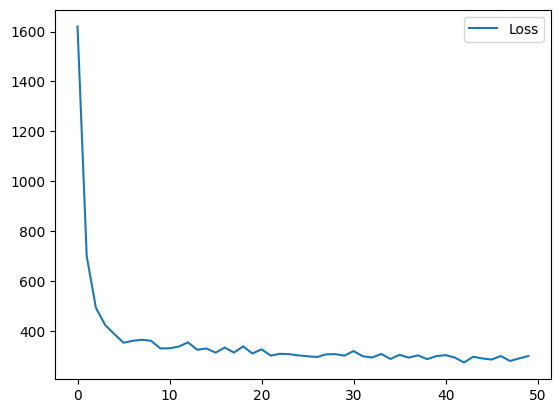

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [ ]:
y_test_pre=model.predict(x_test)
y_train_pre=model.predict(x_train)

y_test_pre.shape,y_test.shape
y_train_pre.shape,y_train.shape

1253/1253 [==============================] - 2s 2ms/step


((40089, 1), (40089,))

In [ ]:
y_dat_pred=list(y_test_pre)+list(y_train_pre)
y_dat_act=list(y_test)+list(y_train)
year_dat=list(test_data['Year'])[1:]+list(train_data['Year'])[1:]

In [ ]:
pa=pd.DataFrame()
pa['Prediction']=[i[0] for i in y_dat_pred]
pa['Year']=year_dat
pa['Actual Values']=y_dat_act
pa.head()

,Prediction,Year,Actual Values
0,5164.920410,2022,5229.5
1,5984.759766,2023,6044.2
2,1181.523071,2021,1229.1
3,1940.618042,2022,1957.7
4,1941.694092,2023,1957.7


In [ ]:
pa.groupby('Year')['Prediction'].sum()

Year
2010    24728048.0
2011    25242684.0
2012    28490680.0
2013    32132138.0
2014    35889896.0
2015    39154820.0
2016    41555328.0
2017    45378004.0
2018    48746280.0
2019    55225236.0
2021    54394016.0
2022    68527344.0
2023    79834072.0
Name: Prediction, dtype: float32

In [ ]:
pa.groupby('Year')['Actual Values'].sum()

Year
2010    2.534904e+07
2011    2.555476e+07
2012    2.860712e+07
2013    3.207748e+07
2014    3.613649e+07
2015    3.914672e+07
2016    4.172200e+07
2017    4.538526e+07
2018    4.881630e+07
2019    5.521588e+07
2021    5.529552e+07
2022    6.857170e+07
2023    7.971540e+07
Name: Actual Values, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
def MAPE(actual,prediction):
    mape = np.sqrt(mean_absolute_percentage_error(actual,prediction))
    return mape

In [ ]:
from sklearn.metrics import r2_score
def R2(actual,prediction):
    r2= np.sqrt(r2_score(actual,prediction))
    return r2

In [ ]:
from sklearn.metrics import mean_absolute_error
def MAE(actual,prediction):
    mae= np.sqrt(mean_absolute_error(actual,prediction))
    return mae

RMSE of test

In [ ]:
print(RMSE(y_test,[i[0] for i in y_test_pre]))

2721.1755180670043


RMSE of train

In [ ]:
print(RMSE(y_train,[i[0] for i in y_train_pre]))

2099.395540291813


MAPE of test

In [ ]:
print(MAPE(y_test,[i[0] for i in y_test_pre]))

1.2442657406291893


MAPE of train

In [ ]:
print(MAPE(y_train,[i[0] for i in y_train_pre]))

4.564541670461355


R2 of test

In [ ]:
print(R2(y_test,[i[0] for i in y_test_pre]))

0.9993021248731327


R2 of train

In [ ]:
print(R2(y_train,[i[0] for i in y_train_pre]))

0.9987440902283621


MAE of test

In [ ]:
print(MAE(y_train,[i[0] for i in y_train_pre]))

15.326698308520887


MAE of train

In [ ]:
print(MAE(y_test,[i[0] for i in y_test_pre]))

19.220265477247313


Plot

In [ ]:

grouped_data = pa.groupby('Year').agg({'Prediction': 'sum', 'Actual Values': 'sum'}).reset_index()

trace_pred = go.Scatter(x=grouped_data['Year'], y=grouped_data['Prediction'], mode='lines', name='Prediction', line=dict(color='red'))
trace_actual = go.Scatter(x=grouped_data['Year'], y=grouped_data['Actual Values'], mode='lines', name='Actual Values', line=dict(color='blue'))

fig = go.Figure([trace_pred, trace_actual])
fig.update_layout(
    title='GRU',
    xaxis=dict(title='Year', tickfont=dict(size=14), dtick=1),
    yaxis=dict(title='Total Income (in Million Rs.)', tickfont=dict(size=14)),
    legend=dict(font=dict(size=14))
)

fig.show()


In [ ]:
dataf={'model':['LSTM', 'GRU'],
       'mse_tr':[],
       'mse_tt':[],
       'r2_tr':[],
       'r2_tt':[],
       'mape_tt':[],
       'mape_tr':[],
       'mae_tt':[],
       'mae_tr':[]}